In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy

In [2]:
df = pd.read_table("connect/connect.dat", sep = '\s+', header = None)

number of items:  129
number of flows:  2904951
avg of S(x):  22519.0
parameter phi:  0.00775
parameter epsilon should less than or equal phi
sketch1 belongs to half of the stream
sketch2 belongs to total of the stream


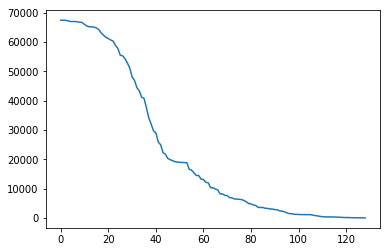

In [3]:
def viewData(df):
    d1 = dict()
    half = dict()
    count = 0
    half_total = len(df.index) / 2
    for line in df.values:
        count += 1
        for item in line:
            if item not in d1.keys():
                d1[item] = 0
            d1[item] += 1
        if count <= half_total:
            half = d1.copy()

    items = sorted(d1, key = d1.get, reverse = True)
    x = range(len(items))
    y = [d1[i] for i in items]
    plt.plot(x, y)
    print("number of items: ", len(items))
    print("number of flows: ", len(df.index) * len(df.columns))
    print("avg of S(x): ", len(df.index) * len(df.columns) / len(items))
    print("parameter phi: ", round(1 / len(items), 5))
    print("parameter epsilon should less than or equal phi")
    realHH = set()
    realHC = set()
    for i,n in d1.items():
        if n >= len(df.index) * len(df.columns) / len(items):
            realHH.add(i)
        if i in half.keys():
            if n - half[i] >= round(len(df.index) / 2) * len(df.columns) / len(items):
                realHC.add(i)
        else:
            if n >= round(len(df.index) / 2) * len(df.columns) / len(items):
                realHC.add(i)
    print("sketch1 belongs to half of the stream")
    print("sketch2 belongs to total of the stream")

    return realHH, realHC

realHH, realHC = viewData(df)

In [4]:
def initSketch(sketch_deep, sketch_width):
    sketch = [[(0,0,0) for x in range(sketch_width)] for y in range(sketch_deep)]
    return sketch

In [5]:
"""参数设置"""
phi = 0.00775
#phi = 0.0084
delta   = 0.05
epsilon = 0.03
r = round(np.log2(1 / delta)).astype(np.int)
w = round(2 / epsilon)
print("r =", r)
print("w =", w)
sketch = initSketch(r, w)

r = 4
w = 67


In [6]:
def update(sketch,item):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    x  = item[0]
    vx = item[1]
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0] + vx
        K = sketch[i][j][1]
        C = sketch[i][j][2]
        if K == x:
            C += vx
        else:
            C -= vx
            if C < 0:
                K = x
                C = -C
        sketch[i][j] = (V, K, C)
    return sketch


In [7]:
def processStream_HH(sketch, df):
    for record in df.values:
        for i in record:
            item = (i,1)
            update(sketch,item)
    return

#processStream_HH(sketch, df)

In [8]:
def processStream_HC(sketch, df):
    count = 0
    half_total = len(df.index) / 2
    for record in df.values:
        count += 1
        for i in record:
            item = (i,1)
            update(sketch,item)
        if count <= half_total:
            sketch1 = copy.deepcopy(sketch)
    return sketch1,sketch

sketch1, sketch2 = processStream_HC(sketch, df)

In [9]:
def queryU(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0]
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = (V + C) / 2
        else:
            S = (V - C) / 2
        res_list.append(S)
    return min(res_list)


In [10]:
def queryL(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = C
        else:
            S = 0
        res_list.append(S)
    return max(res_list)

In [16]:
def hitter(sketch, phi, S):
    print("heavy hitter threshold: ", phi * S)
    hh = set()
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    #for i in range(1,3):
    for i in range(sketch_deep):
        for j in range(sketch_width):
            if sketch[i][j][0] >= phi * S:
                x = sketch[i][j][1]
                if queryU(sketch, x) >= phi * S:
                    hh.add(x)
    return hh
     

In [17]:
S   = len(df.index) * len(df.columns)
resHH = hitter(sketch2, phi, S)

heavy hitter threshold:  22513.37025


In [44]:
def changer(sketch1, sketch2, phi, D):
    print("heavy changer threshold: ", phi * D)
    hc = set()
    sketch_deep  = len(sketch2)
    sketch_width = len(sketch2[0])
    for i in range(sketch_deep):
        for j in range(sketch_width):
            if sketch2[i][j][0] >= phi * D:
                x  = sketch2[i][j][1]
                U1 = queryU(sketch1, x)
                U2 = queryU(sketch2, x)
                L1 = queryL(sketch1, x)
                L2 = queryL(sketch2, x)
                D_estimate = abs(U1-L2) if (abs(U1-L2) > abs(L1-U2)) else abs(L1-U2)
                if D_estimate >= phi * D:
                    hc.add(x)
    return hc

In [18]:
def evaluate(res, real):
    tp = fp = fn = 0
    for i in res:
        if i in real:
            tp += 1
        else:
            fp += 1
    for j in real:
        if j not in res:
            fn += 1
    print("TP =",tp,"   FP =", fp,"   FN =", fn)
    recall = tp / (tp + fn)
    print('reacall:', recall)
    precision = tp / (tp + fp)
    print('precision:',precision)
    f1 = (2 * recall * precision) / (precision + recall)
    print('F1-score:',f1)

In [19]:
evaluate(resHH, realHH)
print(resHH)
print(realHH)

TP = 43    FP = 0    FN = 0
reacall: 1.0
precision: 1.0
F1-score: 1.0
{1, 4, 7, 10, 13, 16, 19, 24, 25, 28, 31, 34, 37, 40, 44, 46, 49, 52, 55, 60, 63, 66, 69, 72, 75, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127}
{1, 4, 7, 10, 13, 16, 19, 24, 25, 28, 31, 34, 37, 40, 44, 46, 49, 52, 55, 60, 63, 66, 69, 72, 75, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127}


In [16]:
D  = round(len(df.index) / 2) * len(df.columns)
resHC = changer(sketch1, sketch2, phi, D)

heavy changer threshold:  11256.5185


In [17]:
evaluate(resHC, realHC)
print(resHC)
print(realHC)

TP = 43    FP = 3    FN = 1
reacall: 0.9772727272727273
precision: 0.9347826086956522
F1-score: 0.9555555555555557
{1, 6, 7, 10, 13, 16, 19, 22, 24, 25, 28, 31, 34, 37, 40, 44, 46, 49, 52, 55, 60, 63, 66, 69, 72, 75, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 113, 114, 115, 118, 121, 124, 127}
{1, 6, 7, 10, 13, 16, 19, 24, 25, 28, 31, 34, 37, 40, 44, 46, 49, 52, 55, 60, 63, 66, 69, 72, 75, 76, 77, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127}
